In [0]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.model_selection
import sklearn.linear_model
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt
import multiclassLogReg as mcl
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers

In [0]:
# Import the fifa_processed_FINAL.csv and multiClassLogReg.py file here.
from google.colab import files
uploaded = files.upload()


# Final Project by Nicolas Oshiro
## Introduction

For my final project, I chose to evaluate a dataset from Kaggle and attempted many different classification algorithms that we learned in the class to see which one works best on this specific dataset. 

## Data and Processing

The dataset I chose is a collection of all the player statistics from the popular video game FIFA by EA Sports. The data can be found [here](https://www.kaggle.com/karangadiya/fifa19). Taking a look at the raw data we can see that it contains 18,207 rows and 89 columns. Each row is a player and the columns contain player attributes (name, age, club, nationality, etc.) as well as their skill ratings on a scale of 0 to 100 for various categories (Crossing, Finishing, Marking, etc.). I am interested to see if I could use these skill attributes to predict the position of a player.

I processed the data in R and the file can be found [here](https://github.com/nicoshiro/Math-373-Final-Project/blob/master/fifa_processing.R). I first removed all of the Goal Keepers from the dataset because they would skew the data since they do not play a traditional position. I also removed players that had null values for their position. Next, I subsetted the data to only include the skill attributes that I mentioned before. Lastly, the dataset included a wide range of positions that I simplified into 3 basic categories, Forward, Midfielder, and Defender. In order to run the algorithms properly I encoded the 3 main positions with numbers, 1 being Defender, 2 being Midfielder, and 3 being Forward. With this dataset I began to use the different classification algorithms to see if I could classify these players into the correct position category.

These are functions that run in the FIFA dataset. The load_fifa() function reads in the data and extracts the feature vectors, X, and the classes, Y. The load_fifa_one_hot() function similarly reads in the data and extracts the feature vectors, X, but it extracts the classes and then one hot encodes them.

In [0]:
def load_fifa():
    
    data = pd.read_csv("fifa_processed.csv")
    Y = data['SimplePositionNum']
    data = data.drop('SimplePositionNum',axis = 1)
    
    X = data.values
    numExamples = X.shape[0]
    allOnes = np.ones((numExamples,1))
    X = np.concatenate((X,allOnes),axis = 1)
    
    return (X,Y)

def load_fifa_one_hot():
    
    data = pd.read_csv("fifa_processed.csv")
    oneHot = pd.get_dummies(data['SimplePositionNum'])
    data = data.drop('SimplePositionNum',axis = 1)
    
    X = data.values
    Y = oneHot.values
    numExamples = X.shape[0]
    allOnes = np.ones((numExamples,1))
    X = np.concatenate((X,allOnes),axis = 1)
    
    return (X,Y)

## Multiclass Logistic Regression

I started off by using Multiclass Logistic Regression to try and classify the data. My first attempt at MLR uses the function that I built for Project 3. I opted to use stochastic gradient descent instead of normal gradient descent because it ran faster on the dataset. The following code reads in the data, estimates the betas, and plots the costs of each epoch.

In [0]:
%%capture
# Read in and process the data
X, Y = load_fifa_one_hot()
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)
numExam, numFeat = X_train.shape
numExam, numClasses = Y_train.shape
beta = np.random.randn(numFeat, numClasses)

# Create model using stochastic gradient descent and the training data
(beta, costs) = mcl.multiclassLogReg_SGD(X_train, Y_train, .0001)

In [55]:
# Process test data
numExamples, numFeatures = X_test.shape

# Determine the amount of examples the function correctly assigned
numCorrect = 0
for i in range(numExamples):
    xi = X_test[i,:]
    yi = Y_test[i]
    
    dotProds = xi @ beta
    terms = np.exp(dotProds)
    probs = terms/np.sum(terms)
    
    k = np.argmax(probs)
    if yi[k] == 1:
        numCorrect += 1

ratio = numCorrect/numExamples
print("Accuracy: " + str(ratio))

Accuracy: 0.8545100124047492


As we can see, this algorithm outputs a fairly descent accuracy, but if we take a look at the costs we can see that they do not get smaller with each epoch.

Text(0.5, 1.0, 'Costs of Multi Class Logisitic Regression')

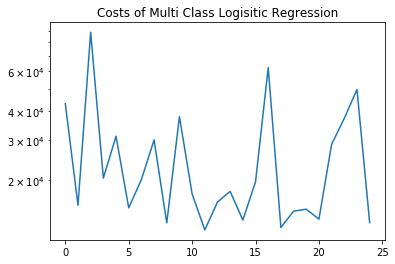

In [56]:
# Plot the costs
plt.figure
plt.semilogy(costs)
plt.title("Costs of Multi Class Logisitic Regression")

A consequence of this is the model outputs very different accuracies each time it is run so in an attempt to mitigate this fact I ran the model 10 different times and took the average accuracy from the 10 attempts.

In [0]:
%%capture
average_accuracy = 0
iters = 10

for i in range(iters):
  # Read in and process the data
  X, Y = load_fifa_one_hot()
  X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)
  numExam, numFeat = X_train.shape
  numExam, numClasses = Y_train.shape
  beta = np.random.randn(numFeat, numClasses)

  # Create model using stochastic gradient descent and the training data
  (beta, costs) = mcl.multiclassLogReg_SGD(X_train, Y_train, .0001)
  
  # Process test data
  numExamples, numFeatures = X_test.shape

  # Determine the amount of examples the function correctly assigned
  numCorrect = 0
  for i in range(numExamples):
      xi = X_test[i,:]
      yi = Y_test[i]

      dotProds = xi @ beta
      terms = np.exp(dotProds)
      probs = terms/np.sum(terms)

      k = np.argmax(probs)
      if yi[k] == 1:
          numCorrect += 1
          
  ratio = numCorrect/numExamples
  average_accuracy += ratio

average_accuracy = average_accuracy / iters

In [66]:
average_accuracy = average_accuracy / iters
print('Average Accuracy: ' + str(average_accuracy))

Average Accuracy: 0.007664717348927877


We can see that the average accuracy ends up somewhere around 75 and 80 percent which is not ideal. Now, I wanted to take a look at the Multiclass Logisitic Regression function in scikitlearn to see if it produced better results. Similar to the last example, and in all following examples, I took an average of 10 outcomes of the model to try and provide a more accurate represenation of the model.

In [67]:
# Read in data
X, Y = load_fifa()
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)

average_accuracy = 0
iters = 10
for i in range(iters):
    # Create model with newton-cg optimizer and 10000 iterations
    model = sk.linear_model.LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial', max_iter = 10000)
    model.fit(X_train, Y_train) 
    y_pred = model.predict(X_test)   
    accuracy = metrics.accuracy_score(Y_test, y_pred)  
    average_accuracy += accuracy

average_accuracy = average_accuracy / iters   
print('Average Accuracy: ' + str(average_accuracy))

Average Accuracy: 0.8610668084352293


This model does a little better and outputs an average accuracy of around 85%. Next, I will take a look at a keras neural network classifier to see how it stacks up against Multiclass Logistic Regression.

## Neural Network Classifier

I am using the keras package from tensorflow to build a neural network to classify the data. After testing multiple neural network structures I found this structure to perform the best.

In [0]:
X, Y = load_fifa_one_hot()
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)
numExamples, numFeatures = X_test.shape

network = models.Sequential()
network.add(layers.Dense(32,activation = 'relu',))
network.add(layers.Dense(3, activation = 'softmax'))

network.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',\
                metrics = ['accuracy'])

In [0]:
%%capture
average_accuracy = 0
iters = 10

# Run the model 10 times and compute average accuracy
for i in range(iters):
  
  network.fit(X_train,Y_train, epochs = 50, batch_size = 128)
  test_loss, test_acc = network.evaluate(X_test,Y_test)
  
average_accuracy += test_acc

average_accuracy = average_accuracy/iters

In [85]:
print('Average Accuracy: ' + str(test_acc))

Average Accuracy: 0.8630161


This model outputs something similar to the Multiclass Logistic Regression function with an average accuracy of somewhere around 85% - 87%. The next method I will attempt is Support Vector Machines.

## Support Vector Machines

In class we talked about Support Vector Machines as a binary classifying algorithm, but when I was doing research for this project I found that scikit learn supports mulitclass classification for SVMs. For this examples, I extract the first 5000 examples because using the entire dataset took too long for this method.

In [88]:
# Load and process the data
X, Y = load_fifa()
X = X[0:5000,:]
Y = Y[0:5000,]
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)
Y_test = Y_test.values

# Create the SVC model
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, Y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# Calculate model accuracy
accuracy = svm_model_linear.score(X_test, Y_test) 
  
accuracy

0.8668571428571429

Unsurprisingly, this method does a about the same as the previous ones by consistently outputting an accuracy of around 86% - 87%. 

## K-Nearest Neighbors Classifier

K-Nearest Neighbors is an algorithm that we discussed in class, but we didn't dive into or code from scratch. This algorithm is interesting because it outputs the same thing for the same number of nearest neighbors. In order to try and find the optimal number of nearest neighbors I ran this algorithm with up to 20 nearest neighbors and extracted the best accuracy.

In [98]:
# Load and process the data
X, Y = load_fifa()
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size = .35)
Y_test = Y_test.values
best_accuracy = 0
best_neighbors = 0
iters = 20

# Train the model to find optimal nearest neighbors
for i in range(1, iters):
  knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, Y_train)
  accuracy = knn.score(X_test, Y_test)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_neighbors = i
  
print("Optimal neighbors: " + str(best_neighbors))
print("Accuracy: " + str(accuracy))

Optimal neighbors: 17
Accuracy: 0.86


The optimal number of neighbors is 17 and outputs an accuracy of 86%.

## Conclusion

Unfortunately, the results of this project are a little bit boring, but for this dataset all of the classifiers have a similar output maxing out at around 87%. This could potentially be because some players are categorized as a midfielder, but they have a more defensive style of play or attacking style of play. Nevertheless, 87% is not a terrible clasification rate, but it could definitely be improved. For future research on this topic I would be interested to see how well these algorithms perform by attempting to classify the players into the original position types. It would also be interesting to see if you could create a model that cluster players into "new" position types based on their statistics.